# 1. Preparación de entorno






In [ ]:
%pip install --no-cache-dir scikit-learn==1.5.2 kaggle tqdm seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 257.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [ ]:
# info de la gpu
!nvidia-smi

# imports
import sys, sklearn
print("Python:", sys.version)
print("scikit-learn:", sklearn.__version__)

import tensorflow as tf
print("TensorFlow:", tf.__version__)

# memory growth + mixed precision
for g in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(g, True)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

Thu Nov  6 09:41:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import sys, os, pkg_resources, subprocess
import sklearn
print("TensorFlow:", tf.__version__, "| sklearn:", sklearn.__version__)

TensorFlow: 2.19.0 | sklearn: 1.6.1


/tmp/ipython-input-73389311.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, os, pkg_resources, subprocess


#2. HAM10000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpoints"

Mounted at /content/drive


In [ ]:
!unzip -q -o '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000.zip' -d /content/data

#3. Crear dataframe y mapa de clases

In [ ]:
IMG_DIRS = [
    '/content/data/ham10000_images_part_1',
    '/content/data/ham10000_images_part_2'
]
META_CSV = '/content/data/HAM10000_metadata.csv'

#carga del CSV de metadatos
df = pd.read_csv(META_CSV)
# clases de HAM10000: akiec, bcc, bkl, df, mel, nv, vasc
label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
id2name   = {v:k for k,v in label_map.items()}
df['label'] = df['dx'].map(label_map)

'''
find_path: Busca la ruta de la imagen en IMG_DIRS
  ENTRADA:
    image_id: nombre de la imagen sin extension
  SALIDA:
    ruta de la imagen si la encuentra
'''
def find_path(image_id):
    for d in IMG_DIRS:
        p = f"{d}/{image_id}.jpg"
        if os.path.exists(p): return p
    return None
df['filepath'] = df['image_id'].apply(find_path)
df = df.dropna(subset=['filepath']).reset_index(drop=True)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,filepath
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,/content/data/ham10000_images_part_1/ISIC_0027...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,/content/data/ham10000_images_part_1/ISIC_0025...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,/content/data/ham10000_images_part_1/ISIC_0026...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,/content/data/ham10000_images_part_1/ISIC_0025...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,/content/data/ham10000_images_part_2/ISIC_0031...


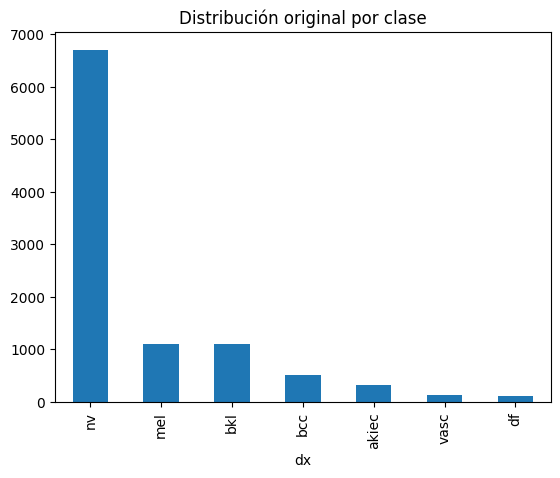

In [ ]:
#distribucion de las clases
df['dx'].value_counts().plot(kind='bar'); plt.title('Distribución original por clase'); plt.show()

In [ ]:
#Split 80/20
'''
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
len(train_df), len(test_df)

SyntaxError: incomplete input (ipython-input-660047118.py, line 2)

#Cargar pesos

In [ ]:
#cargar pesos guardados
import tensorflow as tf

CKPT_DIR = "/content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpoints"

inception = tf.keras.models.load_model(f"{CKPT_DIR}/inception_best.keras")
xception  = tf.keras.models.load_model(f"{CKPT_DIR}/xception_best.keras")
concat_model    = tf.keras.models.load_model(f"{CKPT_DIR}/incepx_concat_best.keras")

print("Modelos cargados correctamente")


Modelos cargados correctamente


#4. Redimensionamiento de datos y data augmentation

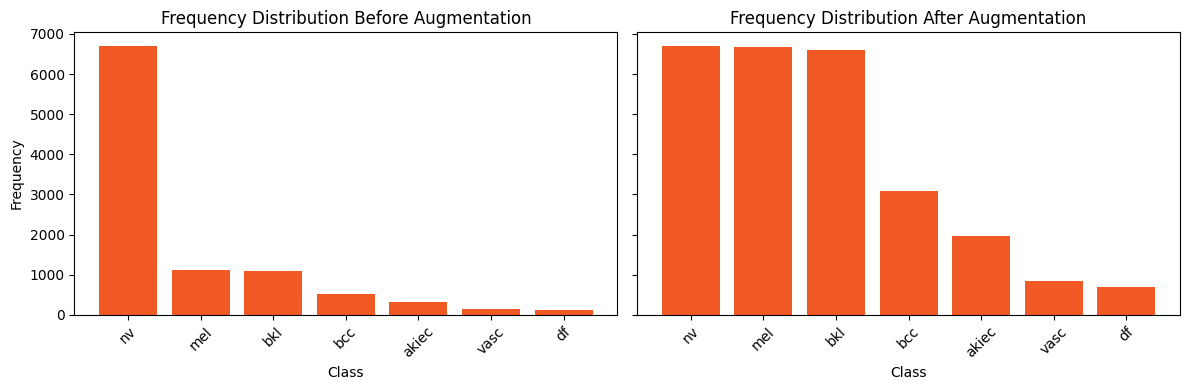

Orden de clases (mayor→menor): ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
Antes : {'nv': np.int64(6705), 'mel': np.int64(1113), 'bkl': np.int64(1099), 'bcc': np.int64(514), 'akiec': np.int64(327), 'vasc': np.int64(142), 'df': np.int64(115)}
Después: {'nv': np.int64(6705), 'mel': np.int64(6678), 'bkl': np.int64(6594), 'bcc': np.int64(3084), 'akiec': np.int64(1962), 'vasc': np.int64(852), 'df': np.int64(690)}


In [ ]:
# =========================
# CONFIGURACION
# =========================
IMG_SIZE    = 299
AUTOTUNE    = tf.data.AUTOTUNE
NUM_CLASSES = 7
BATCH_SIZE  = 32

SHUF_TRAIN  = 4096
PREFETCH    = 2
TEST_ONLY_ORIGINAL = False   # usar solo originales

import tensorflow as tf, numpy as np, pandas as pd, math, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
id2name   = {v:k for k,v in label_map.items()}

# =========================
# AUMENTACIONES
# =========================
'''
decode_resize: Decodifica jpg a tensor
               Redimensiona a IMG_SIZE (299,299)
  ENTRADA:
    path: ruta al archivo .jpg
  SALIDA:
    tensor (299,299,3)
'''
def decode_resize(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method='bilinear')
    return tf.cast(img, tf.float32)/255.0

'''
apply_variant: aplicar una de las 6 tranforaciones sobre img
  ENTRADA:
    img: tensor (299,299,3)
    variant: tensor escalar [0-5]
  SALIDA:
    tensor img transformado (299,299,3)
'''
def apply_variant(img, variant):
    branch = [
        lambda: img, #original
        lambda: tf.image.rot90(img, 1), # 90°
        lambda: tf.image.rot90(img, 3), # 270°
        lambda: tf.image.rot90(img, 2), # 180°
        lambda: tf.image.flip_left_right(img),# flip izq <-> der
        lambda: tf.image.flip_up_down(img)# flip arriba <-> abajo
    ]
    return tf.switch_case(variant, branch) # usa lista de funciones lambda

'''
row_to_example: Lee y preprocesa la imagen (decodifica y resize)
                Aplica una de las 6 transformaciones sobre la imagen
                Convierte label a one-hot
  ENTRADA:
    path: ruta al archivo .jpg
    label: tensor escalar [0-6] (indice de clase)
    variant: tensor escalar [0-5] (transformacion a aplicar)
  SALIDA:
    par de tensores (img, label) -> (inputs,targets)
'''
def row_to_example(path, label, variant):
    img = decode_resize(path)
    img = apply_variant(img, variant)
    y   = tf.one_hot(label, NUM_CLASSES)
    return img, y

# =========================
# CREAR DATAFRAME AUMENTADO
# =========================
'''
make_augmented_index: Crea un dataframe con las 6 variantes de cada imagen
  ENTRADA:
    df_original: dataframe original con columnas almenos ['filepath', 'label']
  SALIDA:
    dataframe con columnas ['filepath', 'label', 'variant']
'''
def make_augmented_index(df_original):
    counts = df_original['label'].value_counts().to_dict() #conteo de filas por clase
    majority_label = max(counts, key=counts.get)

    parts = []
    #Iterar por indice de clase
    for c in range(NUM_CLASSES):
        sub = df_original[df_original['label'] == c]
        if c == majority_label:
            # mayoritaria: solo original (variant=0)
            sub = sub.copy()
            sub['variant'] = 0
            parts.append(sub)
        else:
            # minoritarias: original + 5 variantes
            reps = []
            for v in range(6):
                tmp = sub[['filepath', 'label']].copy()
                tmp['variant'] = v
                reps.append(tmp)
            parts.append(pd.concat(reps, ignore_index=True))
    return pd.concat(parts, ignore_index=True) #concatena mayoritaria y minoritaria

df_aug_all = make_augmented_index(df)

# =========================
# SPLIT 80/20
# =========================
train_df_aug, test_df_aug = train_test_split(
    df_aug_all, test_size=0.2, random_state=42, stratify=df_aug_all['label']
)
if TEST_ONLY_ORIGINAL:
    test_df_aug = test_df_aug[test_df_aug['variant']==0].reset_index(drop=True)

# =========================
# CREA DATASET tf.data
# =========================
'''
make_ds: Transforma el df en un pipeline de tf para el entrenamiento y validacion
         compatible con model.fit() y model.evaluate()
  ENTRADA:
    df_split: dataframe con columnas ['filepath', 'label', 'variant']
    shuffle:  booleano para shufflear
              True -> mezcla aleatoriamente los ejemplos (training)
              False -> mantiene el orden (test/validacion)
  SALIDA:
    dataset tf.data.Dataset con filas (inputs, targets)
'''

def make_ds(df_split, shuffle=False):
    paths    = df_split['filepath'].values
    labels   = df_split['label'].values.astype(np.int32)
    variants = df_split['variant'].values.astype(np.int32)
    #crear tf.data.Dataset a partir de tres arrays NumPy
    #cada elemento del Dataset es una tupla (p,l,v)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels, variants))
    #usa row_to_example para transformar (p,l,v) a (img,y)
    ds = ds.map(lambda p,l,v: row_to_example(p,l,v), num_parallel_calls=2)
    if shuffle:
        ds = ds.shuffle(SHUF_TRAIN)
    #agrupa ejemplos en batches de 32
    #img: (299,299,3) -> (32,299,299,3)
    #y  : (7,) -> (32,7)
    ds = ds.batch(BATCH_SIZE).prefetch(PREFETCH)
    return ds

train_ds = make_ds(train_df_aug, shuffle=True)  #dataset con shuffle
test_ds  = make_ds(test_df_aug,  shuffle=False) #dataset sin shuffle

# =========================
# DISTRIBUCION antes y después
# =========================
before_counts = df['label'].value_counts().reindex(range(NUM_CLASSES), fill_value=0).sort_index()
after_counts  = df_aug_all['label'].value_counts().reindex(range(NUM_CLASSES), fill_value=0).sort_index()

sorted_indices = np.argsort(-after_counts.values)
sorted_labels  = [id2name[i] for i in sorted_indices]

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axs[0].bar(sorted_labels, before_counts.values[sorted_indices], color="#f15a24")
axs[0].set_title("Frequency Distribution Before Augmentation")
axs[0].set_xlabel("Class"); axs[0].set_ylabel("Frequency")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(sorted_labels, after_counts.values[sorted_indices], color="#f15a24")
axs[1].set_title("Frequency Distribution After Augmentation")
axs[1].set_xlabel("Class")
axs[1].tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()

print("Orden de clases (mayor→menor):", sorted_labels)
print("Antes :", dict(zip(sorted_labels, before_counts.values[sorted_indices])))
print("Después:", dict(zip(sorted_labels, after_counts.values[sorted_indices])))

#5. Modelo concatenado

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3, Xception

IMG_SIZE = 299
NUM_CLASSES = 7

'''
make_incepX_concat: Modelo concatenado de InceptionV3 y Xception
  ENTRADA:
    dropout:  tasa de Dropout en el cabezal (float entre 0 y 1)
    trainable_backbones: booleano para entrenar backbones
                         False: Congela pesos del backbone
                         True: Permite fine-tuning del backbone
  SALIDA:
    modelo tf.keras.Model listo para compilar/entrenar
'''

def make_incepX_concat(dropout=0.3, trainable_backbones=False):
    inp = layers.Input((IMG_SIZE, IMG_SIZE, 3)) #Tensor a ser consumido por los backbones (299,299,3)

    #Inception y Xception sin la cabeza con pesos preentrenados en ImageNet conectados a la entrada inp (ramas paralelas)
    inc = InceptionV3(include_top=False, weights='imagenet', input_tensor=inp)
    xcp = Xception   (include_top=False, weights='imagenet', input_tensor=inp)

    #GAP2D por rama: promedia dim espaciales (H,W) por canal
    fi = layers.GlobalAveragePooling2D(name="gap_inception")(inc.output) #(None,2048)
    fx = layers.GlobalAveragePooling2D(name="gap_xception")(xcp.output)  #(None,2048)

    z  = layers.Concatenate(name="concat_feats")([fi, fx]) #Une fi y fx a lo largo del eje de features (None,4096)
    z  = layers.Dense(1024, activation='relu')(z)          #capa totalmente conectada (aprende a fusionar ambas representaciones) (None,1024)
    z  = layers.Dropout(dropout)(z)                        #Dropout para mitigar overfitting
    out = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(z)  #Capa de salida (None,7)

    model = models.Model(inp, out, name="IncepX_concat")  #modelo funcional, mapea inp al vector de probabilidades out
    inc.trainable = xcp.trainable = trainable_backbones
    return model

concat_model = make_incepX_concat(dropout=0.3, trainable_backbones=False)  #Instancia con backbones congelados
concat_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),             #Adam con LR = 0.0001
                     loss='categorical_crossentropy',                      #Perdida: categorical_crossentropy
                     metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#6. InceptionV3 y Xception preentrenados

In [ ]:
'''
make_backbone:
  ENTRADA:
    name: nombre del backbone -> inception o xception
    dropout:  tasa de Dropout en el cabezal (float entre 0 y 1)
    trainable_backbones: booleano para entrenar backbones
                         False: Congela pesos del backbone
                         True: Permite fine-tuning del backbone
  SALIDA:
    modelo tf.keras.Model listo para compilar/entrenar
'''

def make_backbone(name='inception', dropout=0.3, trainable_backbone=False):
    inp = layers.Input((IMG_SIZE, IMG_SIZE, 3)) #Tensor a ser consumido por el backbone (299,299,3)
    #Inception o Xception sin la cabeza con pesos preentrenados en ImageNet
    if name == 'inception':
        base = InceptionV3(include_top=False, weights='imagenet', input_tensor=inp)
    else:
        base = Xception   (include_top=False, weights='imagenet', input_tensor=inp)

    #GAP2D sobre feature map, promedia dim espaciales (H,W) por canal
    x = layers.GlobalAveragePooling2D()(base.output) #(None,2048)
    x = layers.Dense(1024, activation='relu')(x)     #capa densa que aprende proyeccion/combinacion de las features del backbone #(None,1024)
    x = layers.Dropout(dropout)(x) #Dropout para mitigar overfitting
    out = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x) #Capa de salida (None,7)
    model = models.Model(inp, out, name=f"{name}_head") #modelo funcional, mapea inp al vector de probabilidades out [inception_head o xception_head]
    base.trainable = trainable_backbone
    return model

#instantiacion de los dos modelos
inception = make_backbone('inception', dropout=0.3, trainable_backbone=False)
xception  = make_backbone('xception',  dropout=0.3, trainable_backbone=False)

#compilacion
for m in (inception, xception):
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-4),   #Adam con LR = 0.0001
              loss='categorical_crossentropy',            #Perdida: categorical_crossentropy
              metrics=['accuracy'])



#7. Callbacks

In [ ]:
#carpeta de guardado
CKPT_DIR = "/content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpoints"
!mkdir -p "$CKPT_DIR"

base_cbs = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy', verbose=1),
]

ckpt_concat = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/incepx_concat_best.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)
ckpt_inc    = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/inception_best.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)
ckpt_xcp    = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/xception_best.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)

cbs_concat = base_cbs + [ckpt_concat]
cbs_inc    = base_cbs + [ckpt_inc]
cbs_xcp    = base_cbs + [ckpt_xcp]

#8. Entrenamiento

In [ ]:
EPOCHS = 100

# Concatenado (modelo único)
hist_concat = concat_model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=cbs_concat, verbose=1)

# Backbones individuales
history_inc = inception.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=cbs_inc, verbose=1)
history_xcp = xception.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=cbs_xcp, verbose=1)

Epoch 1/100
665/665 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5238 - loss: 1.2338
Epoch 1: val_accuracy improved from -inf to 0.69208, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpoints/incepx_concat_best.keras
665/665 ━━━━━━━━━━━━━━━━━━━━ 253s 261ms/step - accuracy: 0.5239 - loss: 1.2335 - val_accuracy: 0.6921 - val_loss: 0.8350 - learning_rate: 1.0000e-04
Epoch 2/100
664/665 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.6877 - loss: 0.8193
Epoch 2: val_accuracy improved from 0.69208 to 0.73141, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpoints/incepx_concat_best.keras
665/665 ━━━━━━━━━━━━━━━━━━━━ 93s 121ms/step - accuracy: 0.6877 - loss: 0.8192 - val_accuracy: 0.7314 - val_loss: 0.7292 - learning_rate: 1.0000e-04
Epoch 3/100
664/665 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.7505 - loss: 0.6795
Epoch 3: val_accuracy improved from 0.73141 to 0.76680, saving model to /content/drive/MyDrive/ucsp/imple

#9. Curvas de entrenamiento

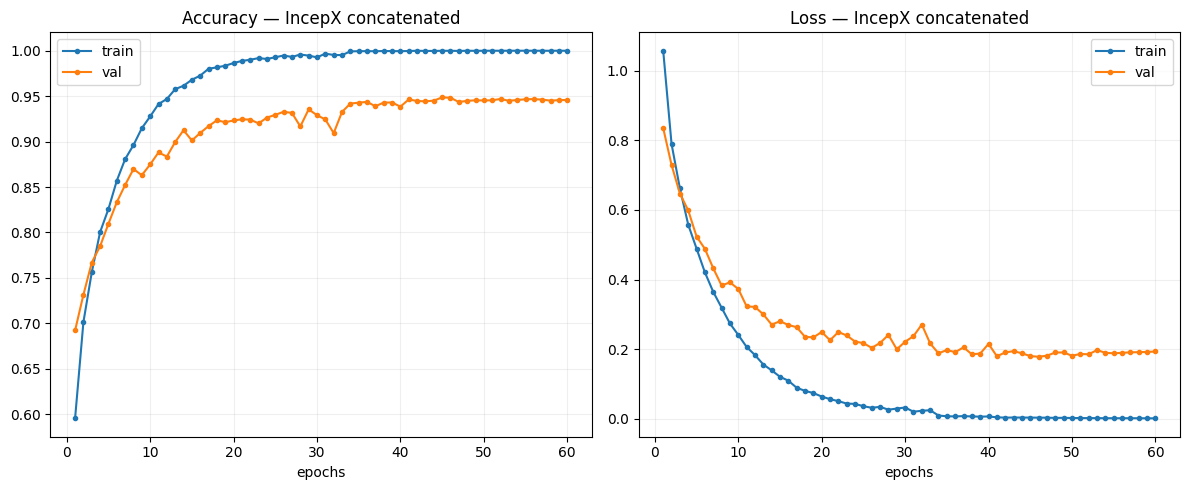

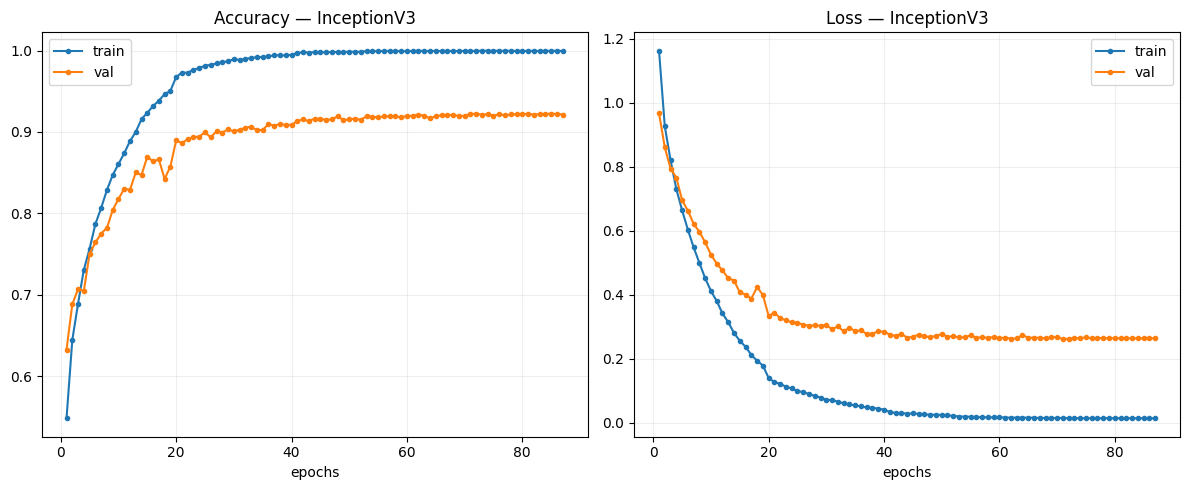

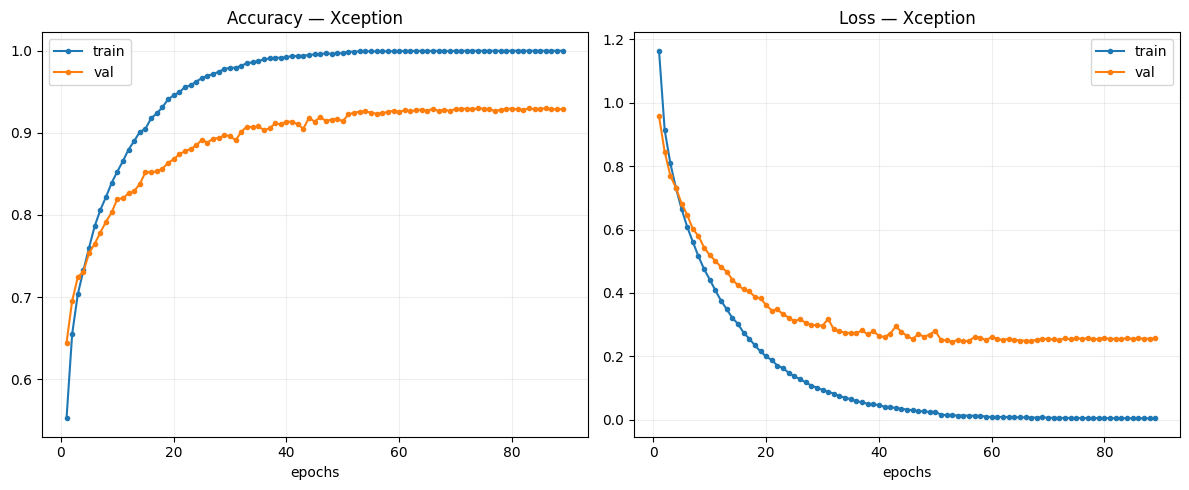

In [ ]:
import matplotlib.pyplot as plt

'''
_get: busca una metrica (key) dentro del dict h.history
  ENTRADA:
   h: objeto History devuelto por model.fit()
   key: nombre de la metrica a recuperar, puede ser 'accuracy' o 'loss'
  SALIDA:
    lista de valores de la metrica en cada epoca
    None si no se encuentra la metrica
'''

def _get(h, key):
    if key in h.history: return h.history[key]
    #versiones antiguas
    if key=='accuracy' and 'acc' in h.history: return h.history['acc']
    if key=='val_accuracy' and 'val_acc' in h.history: return h.history['val_acc']
    return None

'''
plot_history: grafica las curvas de entrenamiento y validacion de una metrica
  ENTRADA:
   h: objeto History devuelto por model.fit()
   title: titulo de la grafica
  SALIDA:
    grafica de entrenamiento y validacion de la metrica
'''

def plot_history(h, title):
    acc, vacc = _get(h, 'accuracy'), _get(h, 'val_accuracy')
    loss, vloss = _get(h, 'loss'), _get(h, 'val_loss')
    #secuencia de epocas
    ep = range(1, len(acc)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(ep, acc, '.-', label='train'); plt.plot(ep, vacc, '.-', label='val')
    plt.title(f'Accuracy — {title}'); plt.xlabel('epochs'); plt.legend(); plt.grid(alpha=.2)
    plt.subplot(1,2,2); plt.plot(ep, loss, '.-', label='train'); plt.plot(ep, vloss, '.-', label='val')
    plt.title(f'Loss — {title}'); plt.xlabel('epochs'); plt.legend(); plt.grid(alpha=.2)
    plt.tight_layout(); plt.show()

plot_history(hist_concat, 'IncepX concatenated')
plot_history(history_inc, 'InceptionV3')
plot_history(history_xcp, 'Xception')

#10. Matrices y ensemble ponderado

Ensemble ponderado → mejor w=0.4992 | F1-macro=0.9590 | Acc=0.9552
== InceptionV3 ==
              precision    recall  f1-score   support

          nv       0.90      0.92      0.91       392
         mel       0.93      0.94      0.93       617
         bkl       0.93      0.94      0.94      1319
         bcc       0.94      0.89      0.91       138
       akiec       0.90      0.95      0.92      1336
        vasc       0.94      0.87      0.90      1341
          df       0.94      0.97      0.95       170

    accuracy                           0.92      5313
   macro avg       0.93      0.93      0.93      5313
weighted avg       0.92      0.92      0.92      5313



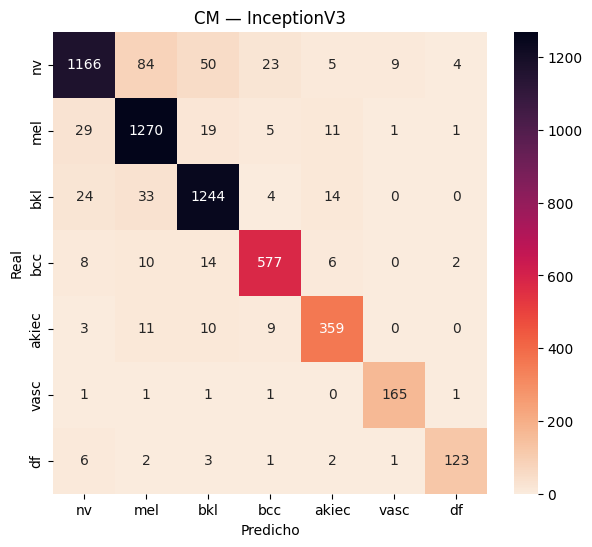

== Xception ==
              precision    recall  f1-score   support

          nv       0.94      0.92      0.93       392
         mel       0.94      0.95      0.95       617
         bkl       0.92      0.95      0.94      1319
         bcc       0.90      0.91      0.91       138
       akiec       0.92      0.95      0.93      1336
        vasc       0.94      0.88      0.91      1341
          df       0.97      0.98      0.97       170

    accuracy                           0.93      5313
   macro avg       0.93      0.94      0.93      5313
weighted avg       0.93      0.93      0.93      5313



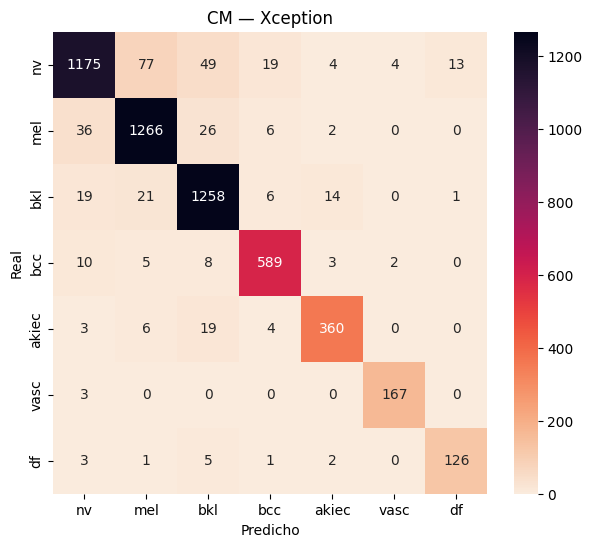

== Concatenado (IncepX Concat) ==
              precision    recall  f1-score   support

          nv       0.97      0.95      0.96       392
         mel       0.94      0.97      0.95       617
         bkl       0.94      0.97      0.96      1319
         bcc       0.95      0.97      0.96       138
       akiec       0.93      0.97      0.95      1336
        vasc       0.97      0.89      0.93      1341
          df       0.96      0.97      0.97       170

    accuracy                           0.95      5313
   macro avg       0.95      0.96      0.95      5313
weighted avg       0.95      0.95      0.95      5313



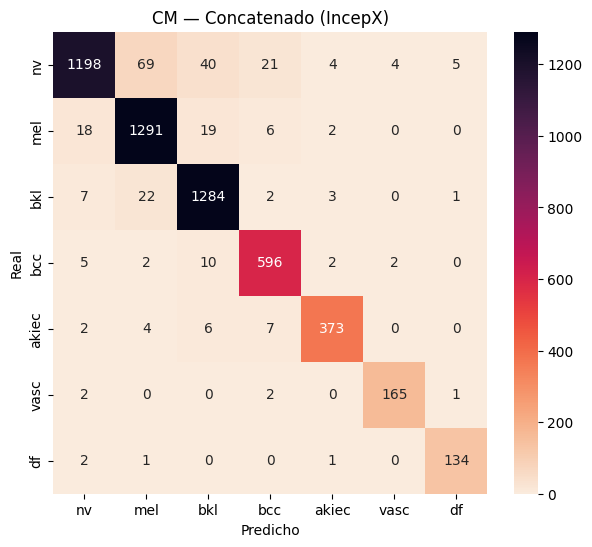

== Ensemble ponderado ==
              precision    recall  f1-score   support

          nv       0.96      0.95      0.96       392
         mel       0.96      0.97      0.97       617
         bkl       0.95      0.97      0.96      1319
         bcc       0.95      0.96      0.95       138
       akiec       0.94      0.98      0.96      1336
        vasc       0.97      0.90      0.93      1341
          df       0.96      1.00      0.98       170

    accuracy                           0.96      5313
   macro avg       0.96      0.96      0.96      5313
weighted avg       0.96      0.96      0.95      5313



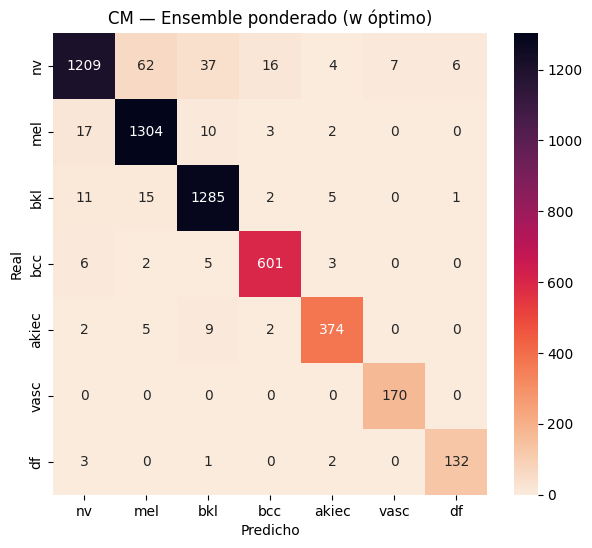

In [ ]:
import numpy as np, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Probabilidades por clase para cada imagen
p_inc = inception.predict(test_ds, verbose=0)
p_xcp = xception.predict(test_ds,  verbose=0)
p_concat = concat_model.predict(test_ds, verbose=0)

# Recorre cada batch de dataset ('_' batch de imagenes, 'y' etiquetas one-hot)
# Conveirte cada tensor 'y' a array Numpy
# Une todos los batches en un solo array (N,7)
# argmax(1) -> convierte one-hot en indice de clase [0-6]
# y_true -> vector 1D de longitud N (una etiqueta real por imagen)
y_true = np.concatenate([y.numpy() for _,y in test_ds], axis=0).argmax(1)

#Ensemble ponderado
best = dict(w=None, f1=-1, acc=-1, preds=None) #dict para guardar mejor resultado
#Grid search de w (2000 combinaciones entre 0 y 1)
for w in np.linspace(0, 1, 2000):
    p_final = w*p_inc + (1-w)*p_xcp
    y_pred  = p_final.argmax(1) #elige a clase con mayor prob final por muestra
    f1 = f1_score(y_true, y_pred, average='macro') #F1-macro: promedio de F1 de todas las clases (sin ponderar por frecuencia)
    acc= accuracy_score(y_true, y_pred)
    #si el nuevo F1 supera al anterior, se guarda el peso y sus metricas en best
    if f1 > best['f1']:
        best.update(w=w, f1=f1, acc=acc, preds=y_pred)

print(f"Ensemble ponderado → mejor w={best['w']:.4f} | F1-macro={best['f1']:.4f} | Acc={best['acc']:.4f}")

# matrices de confusion  en el orden del paper
ordered_classes = ['nv','mel','bkl','bcc','akiec','vasc','df']
label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
ordered_indices = [label_map[c] for c in ordered_classes]

'''
plot_cm: grafica la matriz de confusion
  ENTRADA:
    y_true: vector de etiquetas reales
    y_pred: vector de etiquetas predichas
    title: titulo de la grafica
  SALIDA:
    grafica de la matriz de confusion
'''

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=ordered_indices)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
                xticklabels=ordered_classes, yticklabels=ordered_classes)
    plt.title(title); plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

# Reportes y CMs
class_names = [c for c in ordered_classes]
print("== InceptionV3 ==")
y_inc = p_inc.argmax(1)
print(classification_report(y_true, y_inc, target_names=class_names))
plot_cm(y_true, y_inc, "CM — InceptionV3")

print("== Xception ==")
y_xcp = p_xcp.argmax(1)
print(classification_report(y_true, y_xcp, target_names=class_names))
plot_cm(y_true, y_xcp, "CM — Xception")

print("== Concatenado (IncepX Concat) ==")
y_concat = p_concat.argmax(1)
print(classification_report(y_true, y_concat, target_names=class_names))
plot_cm(y_true, y_concat, "CM — Concatenado (IncepX)")

print("== Ensemble ponderado ==")
print(classification_report(y_true, best['preds'], target_names=class_names))
plot_cm(y_true, best['preds'], "CM — Ensemble ponderado (w óptimo)")

#11. Curva ROC

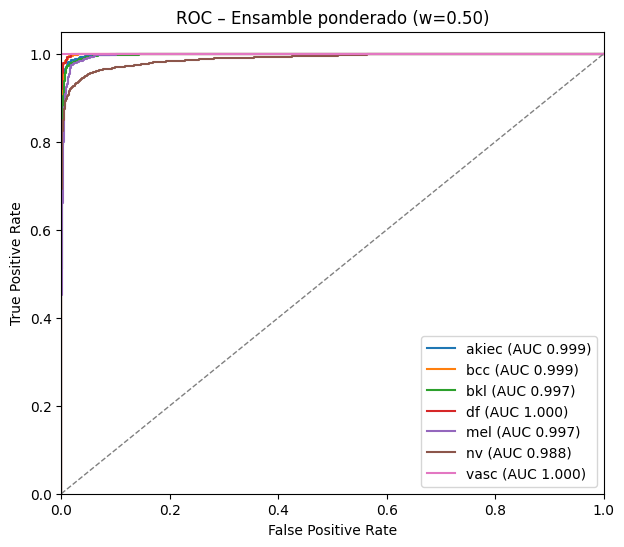

AUCs por clase: {'akiec': '0.999', 'bcc': '0.999', 'bkl': '0.997', 'df': '1.000', 'mel': '0.997', 'nv': '0.988', 'vasc': '1.000'}
AUC micro: 0.997 | AUC macro: 0.997


In [ ]:
# ROC del ensemble
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_true (integers) one-hot para ROC one-vs-rest
y_true_oh = tf.one_hot(y_true, NUM_CLASSES).numpy()

# peso optimo
w = best['w']
if w is None:
    raise ValueError("No hay peso óptimo en 'best'. Asegúrate de haber corrido el grid search antes.")

# combinacion ponderada de probabilidades
probs_best = w * p_inc + (1.0 - w) * p_xcp

# ROC por clase
plt.figure(figsize=(7,6))
aucs = [] #lista de AUC individuales por clase
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_oh[:, i], probs_best[:, i])
    roc_auc = auc(fpr, tpr) #AUC de la clase
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, label=f"{id2name[i]} (AUC {roc_auc:.3f})")
plt.plot([0,1], [0,1], '--', lw=1, color='gray')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'ROC – Ensamble ponderado (w={w:.2f})')
plt.legend(loc='lower right')
plt.show()

print("AUCs por clase:", {id2name[i]: f"{aucs[i]:.3f}" for i in range(NUM_CLASSES)})

# micro y macro ROC
from sklearn.preprocessing import label_binarize
# micro-ROC (rendimiento global sin importar clases)
fpr_micro, tpr_micro, _ = roc_curve(y_true_oh.ravel(), probs_best.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# macro-ROC (promedio de AUCs por clase) (calidad media de discriminacion del modelo)
# da igua peso a cada clase, aunque sea minoritaria
auc_macro = np.mean(aucs)
print(f"AUC micro: {auc_micro:.3f} | AUC macro: {auc_macro:.3f}")